In [ ]:
import logging

import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Подсчитаем общее количество изображений:

In [2]:
data_dir = pathlib.Path("images")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

19794


Взглянем на одно из изображений:

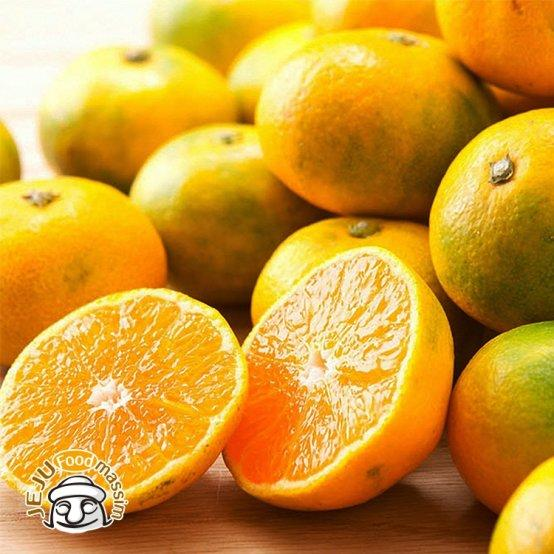

In [3]:
fruits = list(data_dir.glob('фрукты/*'))
PIL.Image.open(fruits[0])

Определим параметры - размер пакета (batch), высоту и ширину изображений:

In [4]:
batch_size = 32
img_height = 256
img_width = 256

Загрузим наши данные, выделив для обучения 70%:

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="training",
  label_mode='categorical',  
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19794 files belonging to 40 classes.
Using 13856 files for training.


2024-04-19 15:20:27.178850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 15:20:27.179075: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 15:20:27.179214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Для валидации загрузим оставшиеся 30%:

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="validation",
  label_mode='categorical',   
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Разделим валидационные данные на тестовую и валидационную выборки:

In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

Взглянем на несколько изображений:

2024-04-19 15:20:30.612905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


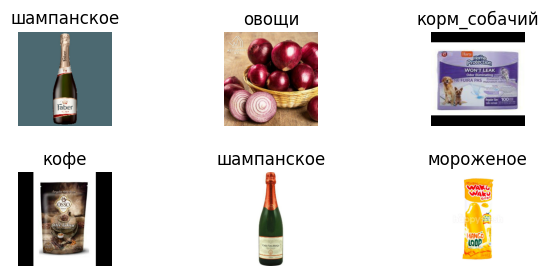

In [8]:
class_names = train_ds.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(2):
  for i in range(6):  
    label = class_names[np.argmax(labels[i])]
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=0.5, wspace=None, hspace=0.5)

Зададим архитектуру нашей модели:

In [24]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_width, img_height, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),  
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),   
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

Определим коллбэки:

In [25]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [26]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/simple_model.weights.h5",
    save_weights_only=True)

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']  
)

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,470,056 (28.50 MB)

 Trainable params: 7,470,056 (28.50 MB)

 Non-trainable params: 0 (0.00 B)

Запустим обучение:

In [28]:
%%time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[checkpoint_cb, es]
)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.0828 - loss: 3.5571 - val_accuracy: 0.2120 - val_loss: 2.8848
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.2099 - loss: 2.8987 - val_accuracy: 0.3079 - val_loss: 2.5115
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.3287 - loss: 2.4503 - val_accuracy: 0.4186 - val_loss: 2.1402
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.4423 - loss: 2.0201 - val_accuracy: 0.4625 - val_loss: 2.0306
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.5294 - loss: 1.6693 - val_accuracy: 0.4909 - val_loss: 1.9513
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.6193 - loss: 1.2942 - val_accuracy: 0.5108 - val_loss: 1.9630
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.6860 - loss: 1.0458 - val_accuracy: 0.5213 - val_loss: 1.9871
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.7531 - loss: 0.8399 - 

Протестируем модель на нашей тестовой выборке:

In [29]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4733 - loss: 2.2059


In [30]:
results

[2.163649082183838, 0.4821908473968506]

In [31]:
predictions = model.predict(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


Иллюстрация того, какие классы были предсказаны для разных изображений. \
В скобках указан предсказанный класс

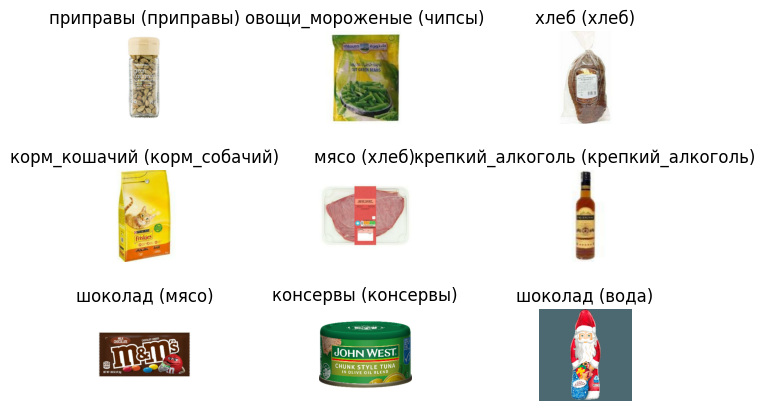

In [32]:
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)

Построим матрицу ошибок:

2024-04-19 15:32:42.781175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


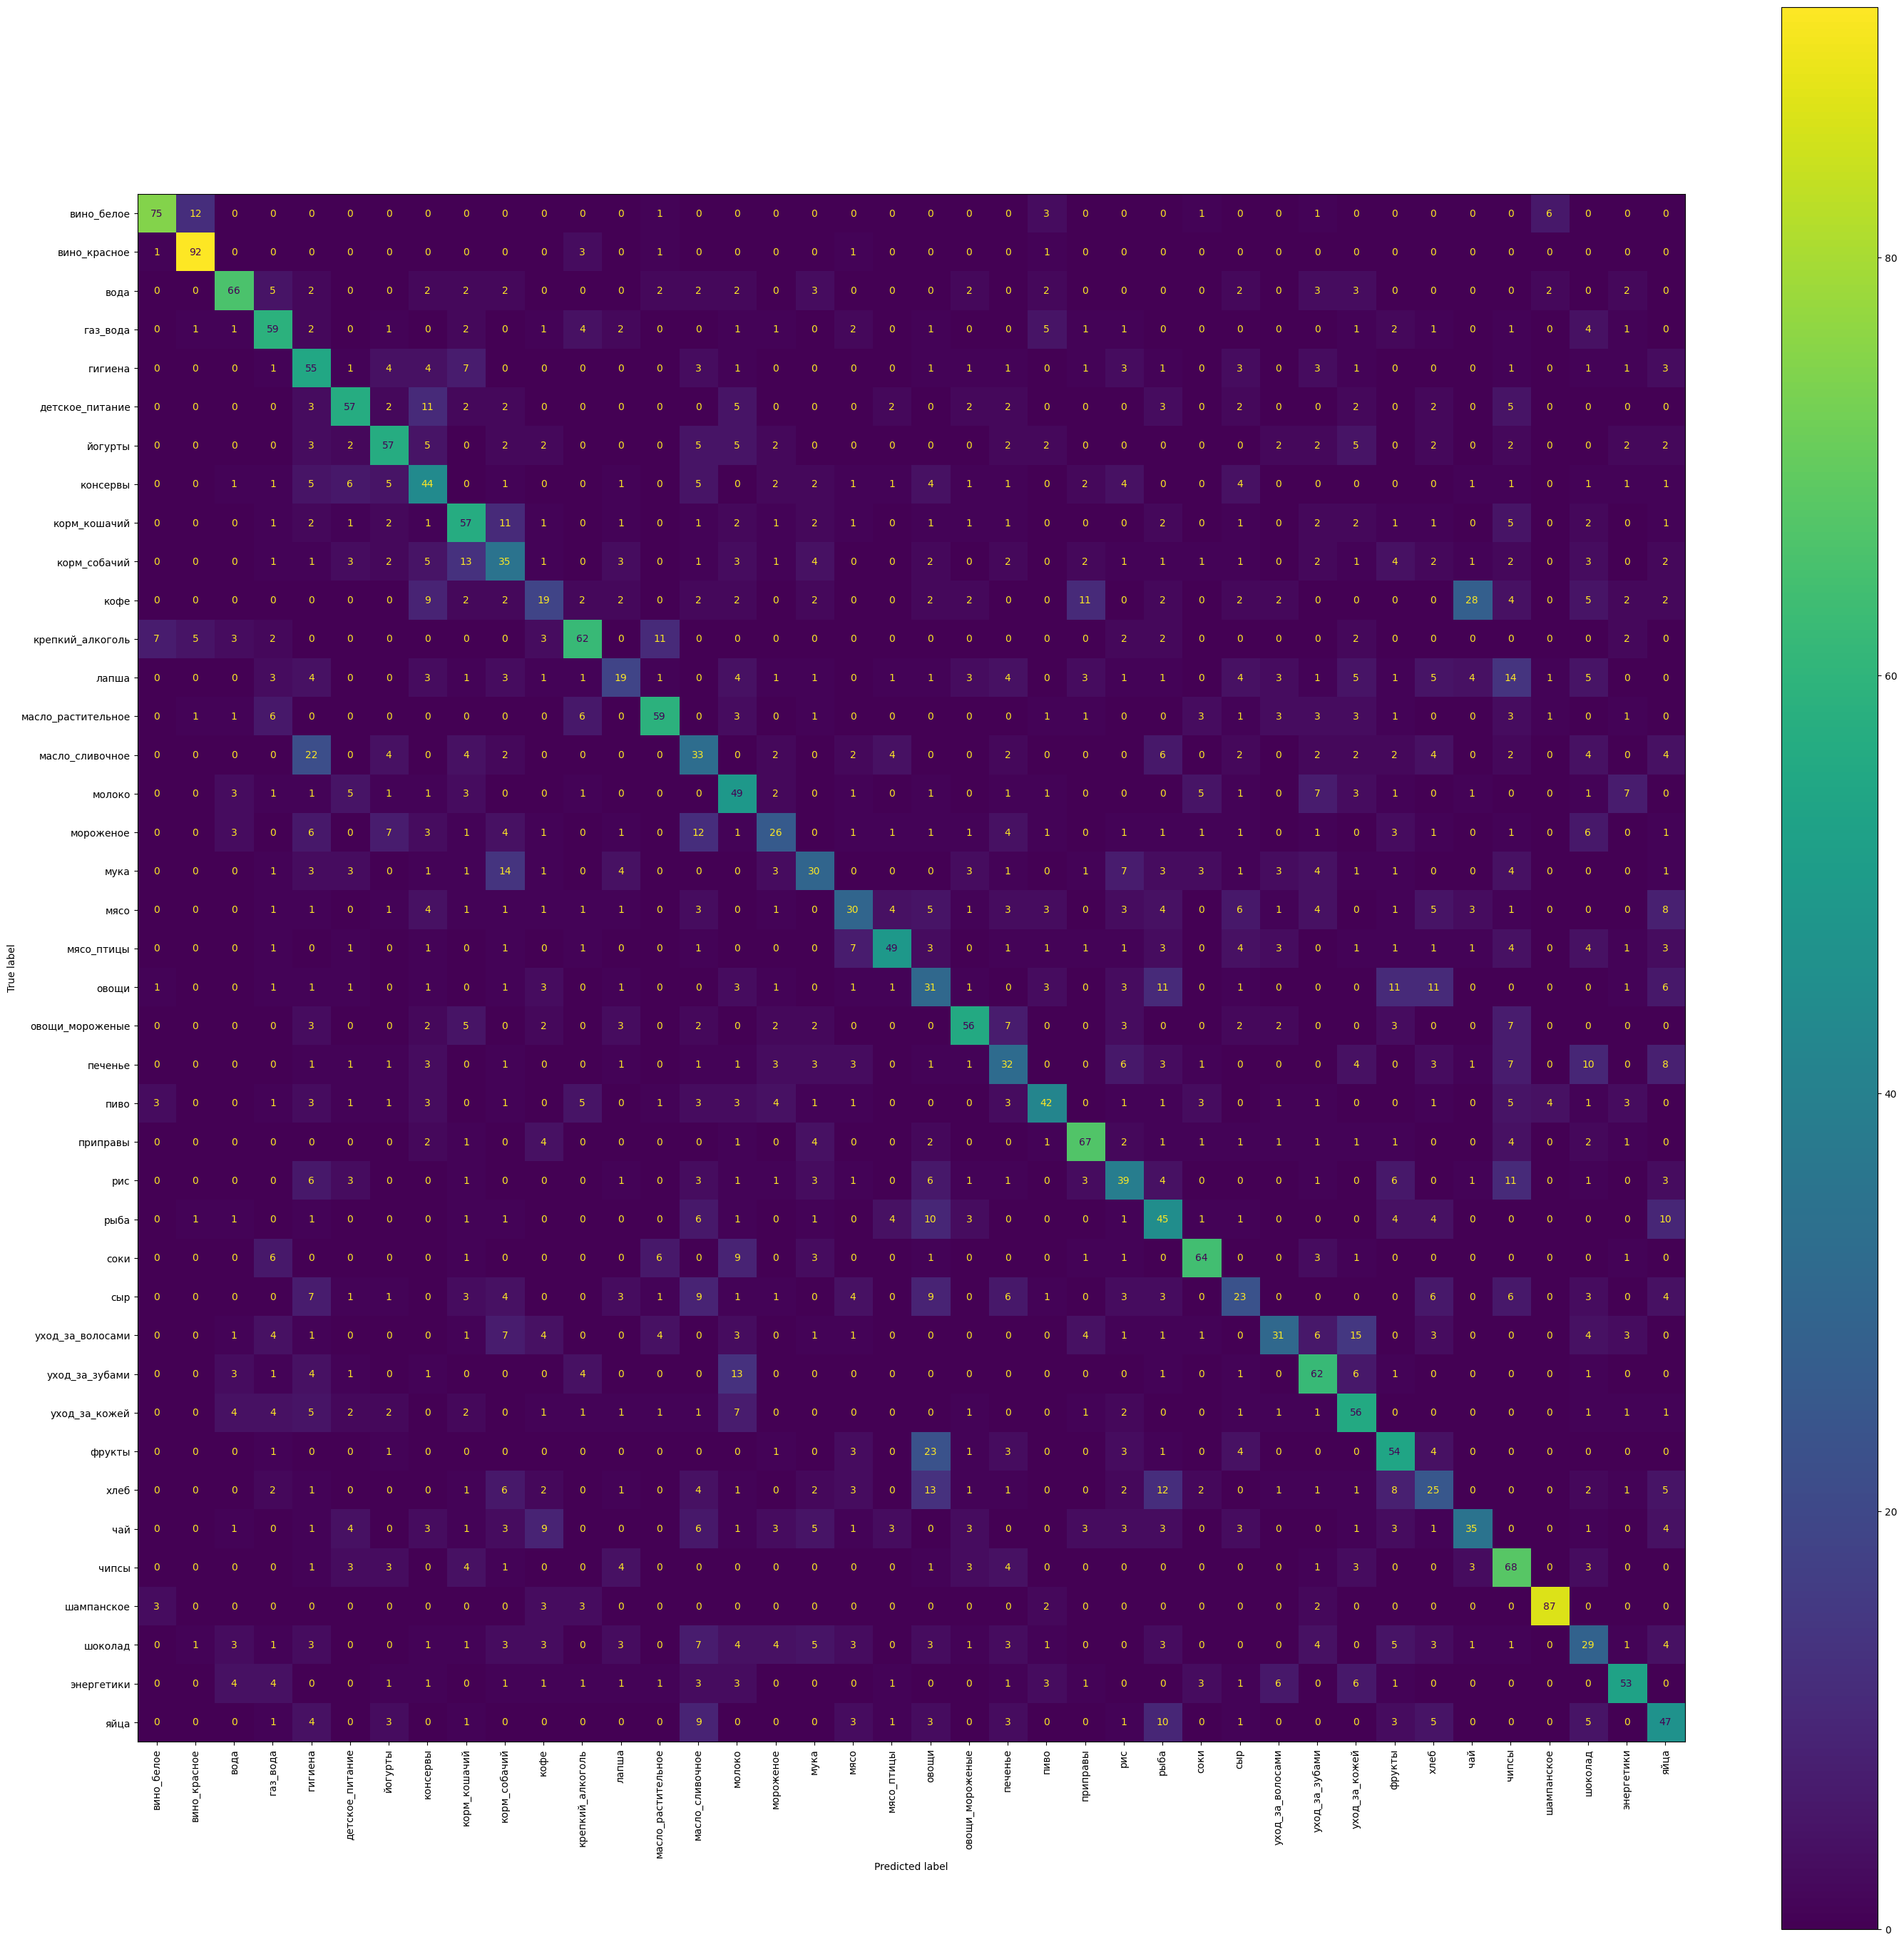

In [33]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

Сохраним натренированную модель:

In [34]:
model.save('ready_models/simple_model.keras')

In [41]:
import json

with open('models_histories/simple_model.json', 'w') as f:
    json.dump(history.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

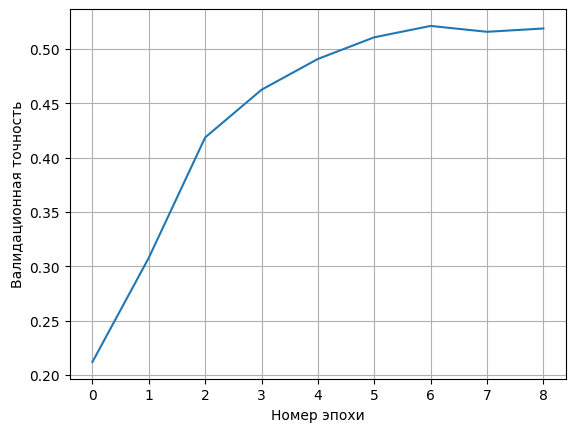

In [56]:
plt.plot(range(len(history.history['accuracy'])), history.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')